# Big Data Symposium Loan Details Notebook

This notebook is the entire process of how the loan details model was made, including any important analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Importing and Cleaning Dataset

In [3]:
def preprocess_data(file_path, na_threshold=0.8, n_components=30):
    df = pd.read_csv(file_path)

    # Identify and remove columns with high NA percentage
    high_na_columns = df.columns[df.isnull().mean() >= na_threshold]
    print(f"Columns removed (>= {na_threshold * 100}% NAs): {list(high_na_columns)}")
    df = df.drop(columns=high_na_columns)

    # Cap outliers using the IQR method for numeric columns
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    
    lei_counts = df['lei'].value_counts()
    # Get the top 50 LEIs (a.k.a the top 10 banks)
    top_10_leis = lei_counts.head(10).index
    df = df[df['lei'].isin(top_10_leis)]

    # State code is dropped due to the dataset only having FL (explained more in report). 
    # Activity year is 2023 and that is the only year we are interested in (no time series analysis) 
    # Census tract is not necessary since we have county codes
    df = df.drop(columns=['activity_year', 'state_code', 'census_tract'])

    return df

processed_df = preprocess_data('state_FL.csv', na_threshold=0.8, n_components=30)
processed_df.head(5)


C:\Users\Jackson Windhorst\AppData\Local\Temp\ipykernel_15544\1224519169.py:2: DtypeWarning: Columns (22,23,24,26,27,28,29,30,31,32,33,38,43,44,46,77,78,79,80) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Columns removed (>= 80.0% NAs): ['total_points_and_fees', 'lender_credits', 'prepayment_penalty_term', 'intro_rate_period', 'multifamily_affordable_units', 'applicant_ethnicity-2', 'applicant_ethnicity-3', 'applicant_ethnicity-4', 'applicant_ethnicity-5', 'co-applicant_ethnicity-2', 'co-applicant_ethnicity-3', 'co-applicant_ethnicity-4', 'co-applicant_ethnicity-5', 'applicant_race-2', 'applicant_race-3', 'applicant_race-4', 'applicant_race-5', 'co-applicant_race-2', 'co-applicant_race-3', 'co-applicant_race-4', 'co-applicant_race-5', 'aus-2', 'aus-3', 'aus-4', 'aus-5', 'denial_reason-2', 'denial_reason-3', 'denial_reason-4']


,lei,derived_msa-md,county_code,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,derived_race,derived_sex,action_taken,...,initially_payable_to_institution,aus-1,denial_reason-1,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
8440,JJKC32MCHWDI71265Z06,42680.0,12061.0,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,Joint,White,Male,4.0,...,1.0,3.0,10.0,6984.0,47.92,79200.0,68.67,1218.0,2105.0,19.0
8469,JJKC32MCHWDI71265Z06,35840.0,12115.0,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,Race Not Available,Sex Not Available,6.0,...,1.0,6.0,10.0,4922.0,8.82,98700.0,123.78,1559.0,2208.0,12.0
8470,JJKC32MCHWDI71265Z06,45300.0,12057.0,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,Joint,Joint,3.0,...,1.0,6.0,10.0,2584.0,52.32,89400.0,102.76,645.0,893.0,50.0
8471,JJKC32MCHWDI71265Z06,35840.0,12115.0,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Joint,White,Joint,2.0,...,1.0,1.0,10.0,5404.0,27.05,98700.0,126.00,1418.0,1907.0,16.0
8472,JJKC32MCHWDI71265Z06,33124.0,12086.0,NC,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,Male,2.0,...,1.0,6.0,10.0,3082.0,57.04,74700.0,203.14,655.0,872.0,67.0


## Information on variables

In [4]:
def summarize_dataset(processed_df):
    # Step 1: Display top 10 most frequent LEIs
    top_10_leis = processed_df['lei'].value_counts().head(10)
    print("Top 10 LEIs:")
    print(top_10_leis)

    # Step 2: Identify object columns
    object_columns = processed_df.select_dtypes(include=['object']).columns
    print("\nObject columns:")
    print(object_columns)

    # Step 3: Display unique values in specified columns
    columns_to_check = [
        'total_units', 'debt_to_income_ratio', 'applicant_age', 
        'co-applicant_age', 'applicant_age_above_62', 'co-applicant_age_above_62'
    ]

    print("\nUnique values in specified columns:")
    for column in columns_to_check:
        if column in processed_df.columns:
            print(f"Unique values in {column}:")
            print(processed_df[column].unique())
        else:
            print(f"Column {column} is not in the DataFrame.")

    # Step 4: Get unique values and their frequencies for key categorical columns
    categorical_columns = [
        'derived_loan_product_type', 'conforming_loan_limit', 'derived_dwelling_category',
        'derived_ethnicity', 'derived_race', 'derived_sex'
    ]

    print("\nUnique values and frequencies for categorical columns:")
    for column in categorical_columns:
        if column in processed_df.columns:
            counts = processed_df[column].value_counts()
            print(f"\nUnique values and frequencies for '{column}':")
            print(counts)
        else:
            print(f"Column {column} is not in the DataFrame.")

summarize_dataset(processed_df)

Top 10 LEIs:
lei
549300HW662MN1WU8550    62759
549300FGXN1K3HLB1R50    37549
RVDPPPGHCGZ40J4VQ731    36390
B4TYDEB6GKMZO031MB27    33546
549300NOCASXPA34X033    31308
X05BVSK68TQ7YTOSNR22    22499
JJKC32MCHWDI71265Z06    22318
5493003GQDUH26DNNH17    21393
5493001SXWZ4OFP8Z903    17547
549300VZVN841I2ILS84    17049
Name: count, dtype: int64

Object columns:
Index(['lei', 'conforming_loan_limit', 'derived_loan_product_type',
       'derived_dwelling_category', 'derived_ethnicity', 'derived_race',
       'derived_sex', 'loan_to_value_ratio', 'interest_rate', 'rate_spread',
       'total_loan_costs', 'origination_charges', 'discount_points',
       'loan_term', 'property_value', 'total_units', 'debt_to_income_ratio',
       'applicant_age', 'co-applicant_age', 'applicant_age_above_62',
       'co-applicant_age_above_62'],
      dtype='object')

Unique values in specified columns:
Unique values in total_units:
[1 2 4 3 '1' '2' '3' '5-24' '100-149' '4']
Unique values in debt_to_income_ratio

#### Preprocessing some data for better visualization

In [5]:
lei_mapping = {
        "549300HW662MN1WU8550": "UNITED WHOLESALE MORTGAGE, LLC",
        "549300FGXN1K3HLB1R50": "ROCKET MORTGAGE, LLC",
        "RVDPPPGHCGZ40J4VQ731": "PENNYMAC LOAN SERVICES, LLC",
        "B4TYDEB6GKMZO031MB27": "Bank of America, National Association",
        "549300NOCASXPA34X033": "LAKEVIEW LOAN SERVICING, LLC",
        "X05BVSK68TQ7YTOSNR22": "Discover Bank",
        "JJKC32MCHWDI71265Z06": "Truist Bank",
        "5493003GQDUH26DNNH17": "NAVY FEDERAL CREDIT UNION",
        "5493001SXWZ4OFP8Z903": "DHI MORTGAGE COMPANY, LTD.",
        "549300VZVN841I2ILS84": "CROSSCOUNTRY MORTGAGE, LLC"
    } # Mapping lei to actual bank name (Looked up the lei codes on a website and manually made a map)

processed_df['institution_name'] = processed_df['lei'].map(lei_mapping)
processed_df = processed_df.drop(columns=['lei'])
cols = ['institution_name'] + [col for col in processed_df.columns if col != 'institution_name']
processed_df = processed_df[cols]


# Columns to process by replacing NaN and converting to float
columns_to_process = [
    'loan_to_value_ratio', 'interest_rate', 'rate_spread', 'total_loan_costs', 
    'origination_charges', 'discount_points', 'loan_term', 'property_value', 
]
for column in columns_to_process:
    processed_df[column] = processed_df[column].fillna(0).astype(float)

## Visualizations

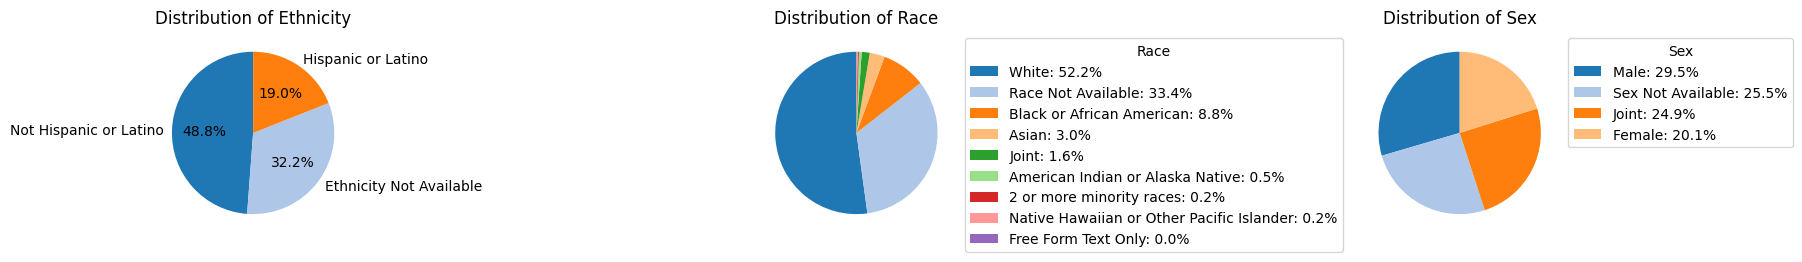

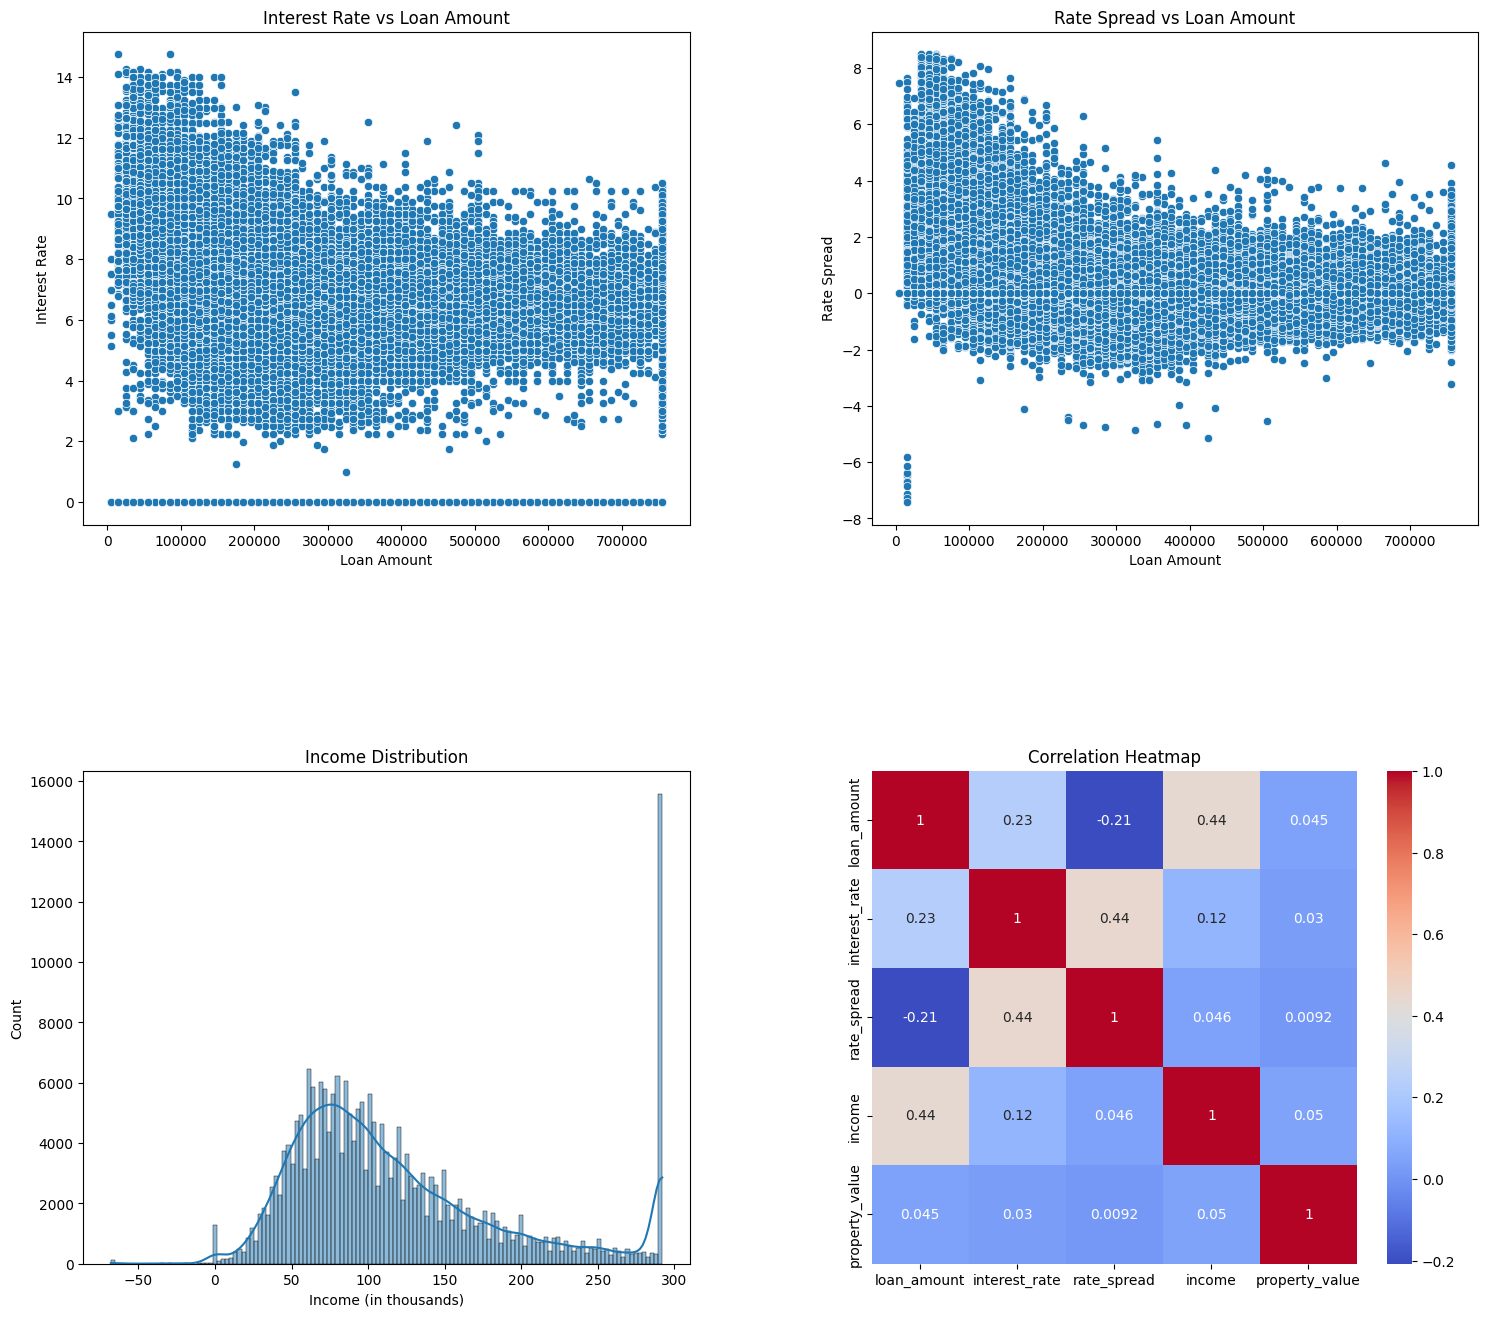

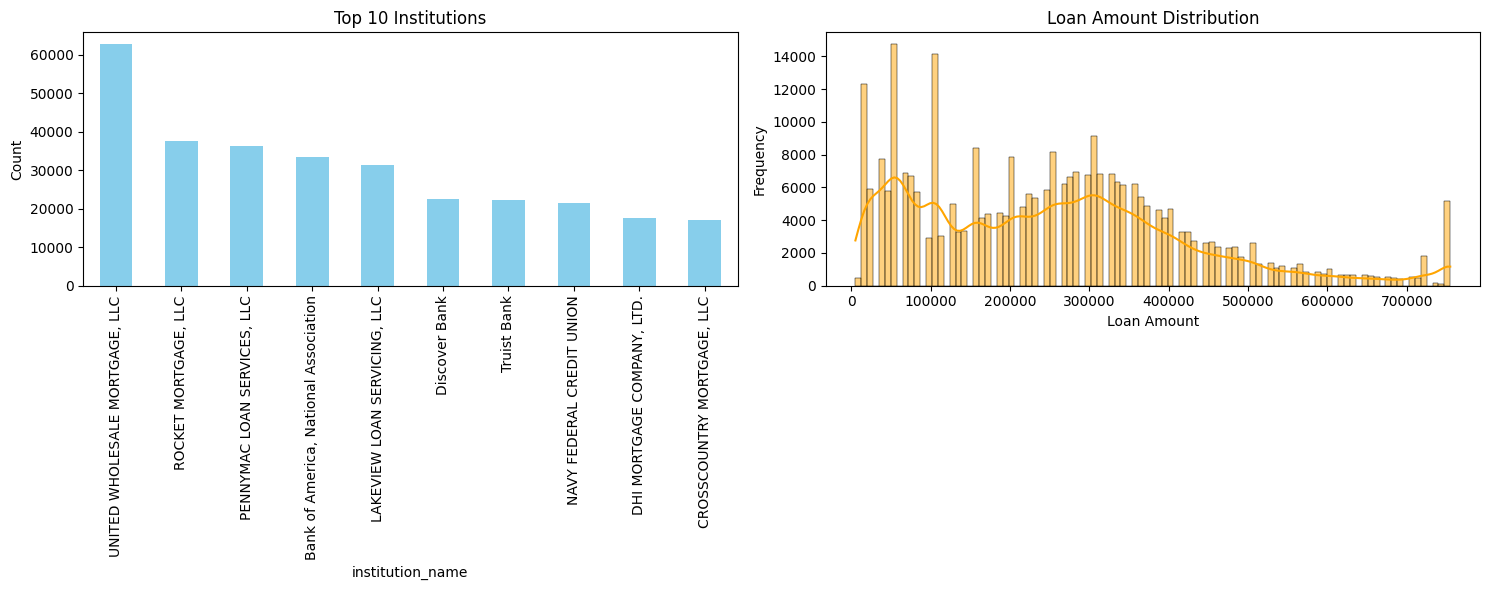

In [6]:
def plot_data(processed_df):
    # Plot 1: Ethnicity, Race, and Sex Pie Charts
    ethnicity_counts = processed_df['derived_ethnicity'].value_counts()
    race_counts = processed_df['derived_race'].value_counts()
    sex_counts = processed_df['derived_sex'].value_counts()

    relevant_categories = ['Not Hispanic or Latino', 'Ethnicity Not Available', 'Hispanic or Latino']
    filtered_ethnicity_counts = ethnicity_counts[ethnicity_counts.index.isin(relevant_categories)]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Ethnicity Pie Chart
    axes[0].pie(
        filtered_ethnicity_counts, 
        labels=filtered_ethnicity_counts.index, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=plt.cm.tab20.colors[:len(filtered_ethnicity_counts)]
    )
    axes[0].set_title("Distribution of Ethnicity")

    # Race Pie Chart (without percentages on plot)
    wedges, texts = axes[1].pie(
        race_counts, 
        startangle=90, 
        colors=plt.cm.tab20.colors[:len(race_counts)],
        pctdistance=0.85,  # Move the labels outside the pie
        labeldistance=None  # Remove the default labels from the pie chart
    )
    labels_with_percentages = [f"{label}: {percentage:.1f}%" for label, percentage in zip(race_counts.index, race_counts / race_counts.sum() * 100)]
    axes[1].legend(
        labels_with_percentages, 
        title="Race",
        loc="upper left", 
        bbox_to_anchor=(1, 1)
    )
    axes[1].set_title("Distribution of Race")

    # Sex Pie Chart (without percentages on plot)
    wedges, texts = axes[2].pie(
        sex_counts, 
        startangle=90, 
        colors=plt.cm.tab20.colors[:len(sex_counts)],
        pctdistance=0.85, 
        labeldistance=None  
    )
    labels_with_percentages = [f"{label}: {percentage:.1f}%" for label, percentage in zip(sex_counts.index, sex_counts / sex_counts.sum() * 100)]
    axes[2].legend(
        labels_with_percentages, 
        title="Sex",
        loc="upper left", 
        bbox_to_anchor=(1, 1)
    )
    axes[2].set_title("Distribution of Sex")

    plt.tight_layout()
    plt.show()

    # Plot 2: Interest Rate vs Loan Amount, Rate Spread, and Correlation Heatmap
    fig, axes = plt.subplots(2, 2, figsize=(18, 16))

    # Interest Rate vs Loan Amount
    sns.scatterplot(x=processed_df['loan_amount'], y=processed_df['interest_rate'], ax=axes[0, 0])
    axes[0, 0].set_title('Interest Rate vs Loan Amount')
    axes[0, 0].set_xlabel('Loan Amount')
    axes[0, 0].set_ylabel('Interest Rate')

    # Rate Spread vs Loan Amount
    sns.scatterplot(x=processed_df['loan_amount'], y=processed_df['rate_spread'], ax=axes[0, 1])
    axes[0, 1].set_title('Rate Spread vs Loan Amount')
    axes[0, 1].set_xlabel('Loan Amount')
    axes[0, 1].set_ylabel('Rate Spread')

    # Income Distribution
    sns.histplot(processed_df['income'], kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Income Distribution')
    axes[1, 0].set_xlabel('Income (in thousands)')

    # Correlation Heatmap
    sns.heatmap(
        processed_df[['loan_amount', 'interest_rate', 'rate_spread', 'income', 'property_value']].corr(), 
        annot=True, cmap='coolwarm', ax=axes[1, 1]
    )
    axes[1, 1].set_title('Correlation Heatmap')

    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.show()

    # Plot 3: Institution Name Bar Chart and Loan Amount Distribution
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Top 10 Institutions
    top_institutions = processed_df['institution_name'].value_counts().head(10)
    top_institutions.plot(kind='bar', ax=axes[0], color='skyblue', title='Top 10 Institutions')
    axes[0].set_ylabel('Count')
    axes[0].tick_params(axis='x')

    # Loan Amount Distribution
    sns.histplot(processed_df['loan_amount'], kde=True, ax=axes[1], color='orange')
    axes[1].set_title('Loan Amount Distribution')
    axes[1].set_xlabel('Loan Amount')
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

plot_data(processed_df)

## Encoding

In [7]:
def encode_dataframe(processed_df):
    # Map for 'total_units'
    total_units_mapping = {
        1: 0, 2: 0, 3: 0, 4: 0,
        '1': 1, '2': 2, '3': 3, '4': 4,
        '5-24': 5, '100-149': 100
    }
    processed_df['total_units'] = processed_df['total_units'].map(total_units_mapping)

    # Map for 'debt_to_income_ratio'
    debt_to_income_mapping = {
        '20%-<30%': 25, '30%-<36%': 33, '<20%': 15, '50%-60%': 55, '>60%': 65,
        '44': 44, '45': 45, '41': 41, '49': 49, '46': 46, '48': 48, '47': 47, 
        '39': 39, '40': 40, '37': 37, '36': 36, '42': 42, '38': 38, '43': 43,
        np.nan: 0
    }
    processed_df['debt_to_income_ratio'] = processed_df['debt_to_income_ratio'].map(debt_to_income_mapping).fillna(0).astype(int)

    # Map for 'applicant_age'
    applicant_age_mapping = {
        '45-54': 50, '25-34': 30, '35-44': 40, '<25': 20, '55-64': 60,
        '65-74': 70, '>74': 75, '8888': 0, 8888: 0
    }
    processed_df['applicant_age'] = processed_df['applicant_age'].map(applicant_age_mapping).fillna(0).astype(int)

    # Map for 'co-applicant_age'
    co_applicant_age_mapping = {
        '25-34': 30, '35-44': 40, '45-54': 50, '55-64': 60, '65-74': 70,
        '>74': 75, '<25': 20, '8888': 0, '9999': 0, 8888: 0
    }
    processed_df['co-applicant_age'] = processed_df['co-applicant_age'].map(co_applicant_age_mapping).fillna(0).astype(int)

    # Map for 'applicant_age_above_62'
    applicant_age_above_62_mapping = {'Yes': 2, 'No': 1}
    processed_df['applicant_age_above_62'] = (
        processed_df['applicant_age_above_62']
        .fillna(0)
        .map(applicant_age_above_62_mapping)
        .fillna(0)
        .astype(int)
    )

    # Map for 'co-applicant_age_above_62'
    processed_df['co-applicant_age_above_62'] = (
        processed_df['co-applicant_age_above_62']
        .fillna(0)
        .map(applicant_age_above_62_mapping)
        .fillna(0)
        .astype(int)
    )
    return processed_df

encode_dataframe(processed_df)
processed_df.head(5)

,institution_name,derived_msa-md,county_code,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,derived_race,derived_sex,action_taken,...,initially_payable_to_institution,aus-1,denial_reason-1,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
8440,Truist Bank,42680.0,12061.0,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,Joint,White,Male,4.0,...,1.0,3.0,10.0,6984.0,47.92,79200.0,68.67,1218.0,2105.0,19.0
8469,Truist Bank,35840.0,12115.0,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,Race Not Available,Sex Not Available,6.0,...,1.0,6.0,10.0,4922.0,8.82,98700.0,123.78,1559.0,2208.0,12.0
8470,Truist Bank,45300.0,12057.0,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,Joint,Joint,3.0,...,1.0,6.0,10.0,2584.0,52.32,89400.0,102.76,645.0,893.0,50.0
8471,Truist Bank,35840.0,12115.0,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Joint,White,Joint,2.0,...,1.0,1.0,10.0,5404.0,27.05,98700.0,126.00,1418.0,1907.0,16.0
8472,Truist Bank,33124.0,12086.0,NC,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,Male,2.0,...,1.0,6.0,10.0,3082.0,57.04,74700.0,203.14,655.0,872.0,67.0


In [8]:
categorical_columns = [
    'derived_loan_product_type',
    'conforming_loan_limit',
    'derived_dwelling_category',
    'derived_ethnicity',
    'derived_race',
    'derived_sex'
]

# Create encoded column names
encoded_columns = [f"{col}_encoded" for col in categorical_columns]

# Encode and replace original columns with encoded columns
for original_col, encoded_col in zip(categorical_columns, encoded_columns):
    processed_df[encoded_col] = pd.Categorical(processed_df[original_col]).codes
    processed_df[encoded_col] = processed_df[encoded_col].astype(int)

# Drop the original categorical columns
processed_df = processed_df.drop(columns=categorical_columns)

In [9]:
# Create a frequency mapping for institution_name
freq_mapping = (
    processed_df['institution_name']
    .value_counts()  # Count the frequency of each institution
    .rank(method='dense', ascending=False)  # Rank based on frequency, with 1 as the highest
    .astype(int)  # Convert to integer
    .to_dict()  # Convert the result to a dictionary
)

# Map the institution_name column to its frequency rank
processed_df['institution_name_encoded'] = processed_df['institution_name'].map(freq_mapping)

# Drop the original institution_name column if not needed
processed_df = processed_df.drop(columns=['institution_name'])

In [10]:
processed_df.head(5)

,derived_msa-md,county_code,action_taken,purchaser_type,preapproval,loan_type,loan_purpose,lien_status,reverse_mortgage,open-end_line_of_credit,...,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units,derived_loan_product_type_encoded,conforming_loan_limit_encoded,derived_dwelling_category_encoded,derived_ethnicity_encoded,derived_race_encoded,derived_sex_encoded,institution_name_encoded
8440,42680.0,12061.0,4.0,0.0,2.0,2.0,1.0,1.0,2.0,2.0,...,1218.0,2105.0,19.0,2,0,2,3,8,2,7
8469,35840.0,12115.0,6.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,...,1559.0,2208.0,12.0,0,0,2,0,7,3,7
8470,45300.0,12057.0,3.0,0.0,2.0,1.0,1.0,1.0,2.0,2.0,...,645.0,893.0,50.0,0,0,2,4,5,1,7
8471,35840.0,12115.0,2.0,0.0,2.0,1.0,1.0,1.0,2.0,2.0,...,1418.0,1907.0,16.0,0,0,2,3,8,1,7
8472,33124.0,12086.0,2.0,0.0,2.0,1.0,1.0,1.0,2.0,2.0,...,655.0,872.0,67.0,0,1,2,4,8,2,7


In [11]:
has_nan = processed_df.isna().any().any()
print(f"Does the DataFrame contain NaN values? {has_nan}")

Does the DataFrame contain NaN values? True


In [12]:
nan_count_per_column = processed_df.isna().sum()
print(nan_count_per_column)

derived_msa-md                          0
county_code                          2661
action_taken                            0
purchaser_type                          0
preapproval                             0
                                     ... 
derived_dwelling_category_encoded       0
derived_ethnicity_encoded               0
derived_race_encoded                    0
derived_sex_encoded                     0
institution_name_encoded                0
Length: 68, dtype: int64


In [13]:
processed_df = processed_df.fillna(0)
print(processed_df.isna().sum())

derived_msa-md                       0
county_code                          0
action_taken                         0
purchaser_type                       0
preapproval                          0
                                    ..
derived_dwelling_category_encoded    0
derived_ethnicity_encoded            0
derived_race_encoded                 0
derived_sex_encoded                  0
institution_name_encoded             0
Length: 68, dtype: int64


## Feature Selection

In [15]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif, mutual_info_regression

def select_important_features(X, y, k='all'):
    
    # Check if it's a classification or regression problem based on y
    if y.dtype == 'object' or y.nunique() < 20:  # Classification problem
        selector = SelectKBest(mutual_info_classif, k=k)
    else:  # Regression problem
        selector = SelectKBest(mutual_info_regression, k=k)

    selector.fit(X, y)
    selected_columns = X.columns[selector.get_support()]
    return X[selected_columns]

X = processed_df.drop(columns=['institution_name_encoded'])  # Features
y = processed_df['institution_name_encoded']  # Target 

# Select the top features 
selected_features = select_important_features(X, y, k=5)

# Print selected features
print("Selected Features:")
print(selected_features.columns)


Selected Features:
Index(['action_taken', 'loan_to_value_ratio', 'interest_rate',
       'submission_of_application', 'aus-1'],
      dtype='object')


## Modeling

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Define the features and target
X = processed_df[['action_taken', 'loan_to_value_ratio', 'interest_rate', 'submission_of_application', 'aus-1']]  # Features
y = processed_df['institution_name_encoded']  # Target (institution_code)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the RandomForestClassifier 
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)  # For AUC, probabilities for all classes

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Multiclass AUC Curve (One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=[i for i in range(len(set(y)))])
fpr, tpr, aucs = {}, {}, {}

# Compute AUC for each class
for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    aucs[i] = roc_auc_score(y_test_bin[:, i], y_prob[:, i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(y_test_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} AUC = {aucs[i]:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass')
plt.legend(loc='lower right')
plt.show()

# Feature importance 
importances = rf_model.feature_importances_
features = X.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.title('Feature Importance')
plt.show()


SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (2316391239.py, line 36)